In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from keras_vggface.vggface import VGGFace
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools

In [2]:
# Load LFW dataset
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4, color=True)

In [3]:
# Extract features and labels
X = lfw_dataset.images
y = lfw_dataset.target
target_names = lfw_dataset.target_names

In [4]:
# Resize images to match expected input size of the vggface Model (224, 224)
X_resized = np.array([resize(image, (224, 224)) for image in X])

In [5]:
# Normalize pixel values to range [0, 1]
X_rescaled = X_resized / 255.0

In [6]:
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [7]:
senet50_model = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3))
last_layer = senet50_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(len(target_names), activation='softmax', name='classifier')(x)
model = Model(senet50_model.input, out)

In [8]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Configure K-Fold Cross-Validation
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [10]:
# Initialize lists to store true positive rates and area under curve values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
# Initialize list to store fold accuracies
fold_accs = []
# Initialize lists to store precision, recall, f1-score, and confusion matrices
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
# Training and Evaluation Loop

for fold, (train_index, val_index) in enumerate(skf.split(X_rescaled, y)):
    print(f"Fold {fold+1}/{num_folds}")
    X_train, X_val = X_rescaled[train_index], X_rescaled[val_index]
    y_train, y_val = y_categorical[train_index], y_categorical[val_index]

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val)
    fold_accs.append(accuracy)

    # Compute predicted probabilities
    y_prob = model.predict(X_val)
    y_pred = np.argmax(y_prob, axis=1)

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_val[:, 1], y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Interpolate tpr to match mean_fpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)

    # Append tpr and auc to lists
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

    # Compute precision, recall, f1-score, and confusion matrix
    precision = precision_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

    # Append precision, recall, f1-score, and confusion matrix to lists
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

Fold 1/10
Epoch 1/10
37/37 [==============================] - 18s 300ms/step - loss: 3.2439 - accuracy: 0.3391 - val_loss: 48913973248.0000 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 10s 267ms/step - loss: 1.8381 - accuracy: 0.3943 - val_loss: 268070.0625 - val_accuracy: 0.4109
Epoch 3/10
37/37 [==============================] - 10s 268ms/step - loss: 1.7435 - accuracy: 0.3943 - val_loss: 151.0663 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 10s 268ms/step - loss: 1.7401 - accuracy: 0.3848 - val_loss: 10.1956 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 10s 274ms/step - loss: 1.6150 - accuracy: 0.4590 - val_loss: 2.5364 - val_accuracy: 0.1860
Epoch 6/10
37/37 [==============================] - 10s 270ms/step - loss: 1.4479 - accuracy: 0.4996 - val_loss: 5.5807 - val_accuracy: 0.1860
Epoch 7/10
37/37 [==============================] - 10s 272ms/step - loss: 1.2907 - accuracy: 0.5522 - val_loss: 2

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 270ms/step - loss: 0.6889 - accuracy: 0.7670 - val_loss: 11.9090 - val_accuracy: 0.1783
Epoch 2/10
37/37 [==============================] - 10s 269ms/step - loss: 0.6064 - accuracy: 0.7877 - val_loss: 10.6639 - val_accuracy: 0.1783
Epoch 3/10
37/37 [==============================] - 10s 269ms/step - loss: 0.5611 - accuracy: 0.7964 - val_loss: 28.1023 - val_accuracy: 0.1783
Epoch 4/10
37/37 [==============================] - 10s 269ms/step - loss: 0.3429 - accuracy: 0.8835 - val_loss: 10.3614 - val_accuracy: 0.1783
Epoch 5/10
37/37 [==============================] - 10s 269ms/step - loss: 0.2187 - accuracy: 0.9275 - val_loss: 4.7508 - val_accuracy: 0.1783
Epoch 6/10
37/37 [==============================] - 10s 269ms/step - loss: 0.2140 - accuracy: 0.9241 - val_loss: 7.6137 - val_accuracy: 0.0620
Epoch 7/10
37/37 [==============================] - 10s 271ms/step - loss: 0.1613 - accuracy: 0.9456 - val_loss: 10.9466 - val_accuracy: 0

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 270ms/step - loss: 0.0964 - accuracy: 0.9672 - val_loss: 31.3432 - val_accuracy: 0.1783
Epoch 2/10
37/37 [==============================] - 10s 268ms/step - loss: 0.1286 - accuracy: 0.9577 - val_loss: 17.2670 - val_accuracy: 0.1783
Epoch 3/10
37/37 [==============================] - 10s 268ms/step - loss: 0.0879 - accuracy: 0.9741 - val_loss: 24.6317 - val_accuracy: 0.1783
Epoch 4/10
37/37 [==============================] - 10s 268ms/step - loss: 0.0338 - accuracy: 0.9905 - val_loss: 12.4385 - val_accuracy: 0.1783
Epoch 5/10
37/37 [==============================] - 10s 268ms/step - loss: 0.0144 - accuracy: 0.9965 - val_loss: 14.3069 - val_accuracy: 0.1783
Epoch 6/10
37/37 [==============================] - 10s 268ms/step - loss: 0.0067 - accuracy: 0.9991 - val_loss: 15.2317 - val_accuracy: 0.1783
Epoch 7/10
37/37 [==============================] - 10s 268ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 4.3835 - val_accuracy: 

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 270ms/step - loss: 0.1245 - accuracy: 0.9551 - val_loss: 12.1185 - val_accuracy: 0.0698
Epoch 2/10
37/37 [==============================] - 10s 268ms/step - loss: 0.4644 - accuracy: 0.8542 - val_loss: 5.5334 - val_accuracy: 0.1163
Epoch 3/10
37/37 [==============================] - 10s 269ms/step - loss: 0.1067 - accuracy: 0.9620 - val_loss: 27.2758 - val_accuracy: 0.0930
Epoch 4/10
37/37 [==============================] - 10s 268ms/step - loss: 0.0564 - accuracy: 0.9784 - val_loss: 23.2841 - val_accuracy: 0.0620
Epoch 5/10
37/37 [==============================] - 10s 271ms/step - loss: 0.0174 - accuracy: 0.9983 - val_loss: 16.2634 - val_accuracy: 0.0775
Epoch 6/10
37/37 [==============================] - 10s 282ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 3.3316 - val_accuracy: 0.3178
Epoch 7/10
37/37 [==============================] - 10s 268ms/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 4.7157 - val_accuracy: 0.

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 270ms/step - loss: 0.0508 - accuracy: 0.9862 - val_loss: 5.6700 - val_accuracy: 0.1938
Epoch 2/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0187 - accuracy: 0.9931 - val_loss: 8.2952 - val_accuracy: 0.1938
Epoch 3/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 2.6287 - val_accuracy: 0.4574
Epoch 4/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 3.4358 - val_accuracy: 0.3643
Epoch 5/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 1.5641 - val_accuracy: 0.5039
Epoch 6/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4225 - val_accuracy: 0.8450
Epoch 7/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9922

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 271ms/step - loss: 0.0945 - accuracy: 0.9689 - val_loss: 6.1742 - val_accuracy: 0.3101
Epoch 2/10
37/37 [==============================] - 10s 268ms/step - loss: 0.1267 - accuracy: 0.9612 - val_loss: 4.8071 - val_accuracy: 0.1550
Epoch 3/10
37/37 [==============================] - 10s 269ms/step - loss: 0.1446 - accuracy: 0.9508 - val_loss: 13.5184 - val_accuracy: 0.1628
Epoch 4/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0690 - accuracy: 0.9776 - val_loss: 9.5913 - val_accuracy: 0.1318
Epoch 5/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0160 - accuracy: 0.9957 - val_loss: 10.8940 - val_accuracy: 0.1085
Epoch 6/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0168 - accuracy: 0.9940 - val_loss: 4.2541 - val_accuracy: 0.2636
Epoch 7/10
37/37 [==============================] - 10s 269ms/step - loss: 0.1594 - accuracy: 0.9431 - val_loss: 10.2285 - val_accuracy: 0.0

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 270ms/step - loss: 0.0142 - accuracy: 0.9940 - val_loss: 8.6504 - val_accuracy: 0.2868
Epoch 2/10
37/37 [==============================] - 10s 270ms/step - loss: 0.0226 - accuracy: 0.9888 - val_loss: 1.5018 - val_accuracy: 0.6202
Epoch 3/10
37/37 [==============================] - 10s 268ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 1.6398 - val_accuracy: 0.5659
Epoch 4/10
37/37 [==============================] - 10s 268ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 1.0604 - val_accuracy: 0.6977
Epoch 5/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.5938 - val_accuracy: 0.8295
Epoch 6/10
37/37 [==============================] - 10s 265ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2433 - val_accuracy: 0.9070
Epoch 7/10
37/37 [==============================] - 10s 265ms/step - loss: 4.5710e-04 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 0.

c:\Users\mynam\OneDrive\Desktop\face-recognition\.conda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 266ms/step - loss: 0.0800 - accuracy: 0.9759 - val_loss: 12.9348 - val_accuracy: 0.1875
Epoch 2/10
37/37 [==============================] - 10s 265ms/step - loss: 0.0384 - accuracy: 0.9879 - val_loss: 4.3004 - val_accuracy: 0.2969
Epoch 3/10
37/37 [==============================] - 10s 265ms/step - loss: 0.0068 - accuracy: 0.9991 - val_loss: 3.4240 - val_accuracy: 0.3203
Epoch 4/10
37/37 [==============================] - 10s 265ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.0115 - val_accuracy: 0.4922
Epoch 5/10
37/37 [==============================] - 10s 265ms/step - loss: 7.9727e-04 - accuracy: 1.0000 - val_loss: 1.2129 - val_accuracy: 0.6641
Epoch 6/10
37/37 [==============================] - 10s 265ms/step - loss: 6.4986e-04 - accuracy: 1.0000 - val_loss: 0.7627 - val_accuracy: 0.7500
Epoch 7/10
37/37 [==============================] - 10s 265ms/step - loss: 5.2660e-04 - accuracy: 1.0000 - val_loss: 0.1677 - val_acc

Normalized confusion matrix


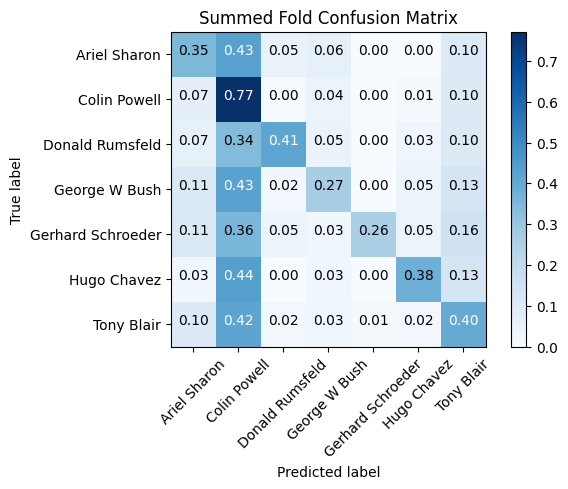

In [13]:
# Plot the summed confusion matrix
sum_conf_matrix = np.sum(conf_matrices, axis=0)
plt.figure()
plot_confusion_matrix(sum_conf_matrix, classes=target_names, normalize=True,
                      title='Summed Fold Confusion Matrix')

In [14]:
# Compute mean accuracy, precision, recall, f1-score
mean_accuracy = np.mean(fold_accs)
mean_precisions = np.mean(precisions)
mean_recalls = np.mean(recalls)
mean_f1_scores = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precisions: {mean_precisions}")
print(f"Mean Recalls: {mean_recalls}")
print(f"Mean F1 Score: {mean_f1_scores}")

Mean Accuracy: 0.3974806196987629
Mean Precisions: 0.4032935476645929
Mean Recalls: 0.39748062015503877
Mean F1 Score: 0.33731659019696086


In [15]:
# Print precision, recall, f1-score, and confusion matrix for each fold
for i in range(num_folds):
    print(f"\nFold {i+1}:")
    print(f"Precision: {precisions[i]}")
    print(f"Recall: {recalls[i]}")
    print(f"F1-Score: {f1_scores[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])


Fold 1:
Precision: 0.03461330448891293
Recall: 0.18604651162790697
F1-Score: 0.05836753305973552
Confusion Matrix:
[[ 0  7  0  0  0  0  0]
 [ 0 24  0  0  0  0  0]
 [ 0 12  0  0  0  0  0]
 [ 0 53  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  8  0  0  0  0  0]
 [ 0 14  0  0  0  0  0]]

Fold 2:
Precision: 0.03178895499068566
Recall: 0.17829457364341086
F1-Score: 0.05395756833945328
Confusion Matrix:
[[ 0  8  0  0  0  0  0]
 [ 0 23  0  0  0  0  0]
 [ 0 12  0  0  0  0  0]
 [ 0 53  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  7  0  0  0  0  0]
 [ 0 15  0  0  0  0  0]]

Fold 3:
Precision: 0.2753875968992248
Recall: 0.18604651162790697
F1-Score: 0.09411790439942215
Confusion Matrix:
[[ 0  8  0  0  0  0  0]
 [ 0 21  0  1  0  0  1]
 [ 1 11  0  0  0  0  0]
 [ 1 49  0  2  0  0  1]
 [ 0 10  0  1  0  0  0]
 [ 0  7  0  0  0  0  0]
 [ 0 14  0  0  0  0  1]]

Fold 4:
Precision: 0.013626453488372093
Recall: 0.11627906976744186
F1-Score: 0.024394210440722066
Confusion Matrix:
[[ 0  0  0  1  0  0  7]
 [ 0

In [16]:
# Compute mean and standard deviation of tpr
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

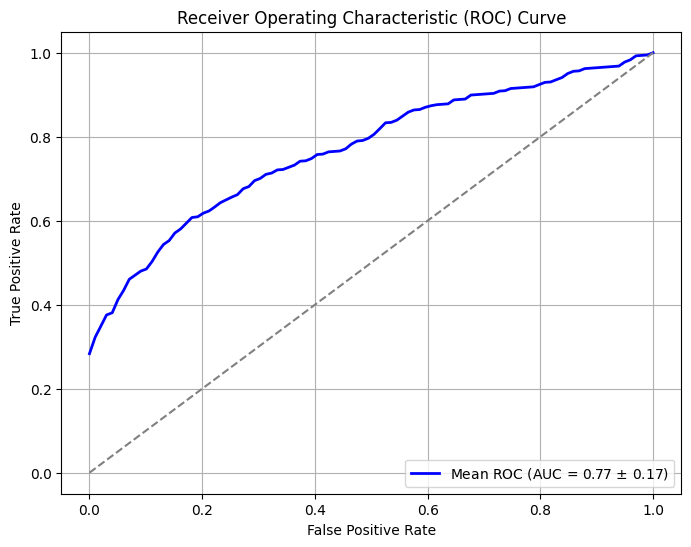

In [17]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()